In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

데이터파일 불러오기 및 구성확인

In [2]:
import pickle
path = "Data/test_data_sets_02.pkl"
with open(path, "rb") as pickle_file:
    test_data_sets = pickle.load(pickle_file)

dict_keys(['Images', 'Metadata'])
dict_keys(['0002_03_F_01', '0003_03_F_01', '0006_03_F_01', '0007_03_F_01', '0008_03_F_01', '0009_03_F_01', '0010_03_F_01', '0011_03_F_01', '0012_03_F_01', '0014_03_F_01', '0016_03_F_01', '0017_03_F_01', '0018_03_F_01', '0019_03_F_01', '0020_03_F_01', '0022_03_F_01', '0023_03_F_01', '0024_03_F_01', '0025_03_F_01', '0026_03_F_01', '0027_03_F_01', '0028_03_F_01', '0029_03_F_01', '0030_03_F_01', '0031_03_F_01', '0032_03_F_01', '0033_03_F_01', '0035_03_F_01', '0036_03_F_01', '0037_03_F_01', '0038_03_F_01', '0039_03_F_01', '0040_03_F_01', '0041_03_F_01', '0042_03_F_01', '0043_03_F_01', '0044_03_F_01', '0045_03_F_01', '0046_03_F_01', '0047_03_F_01', '0048_03_F_01', '0049_03_F_01', '0051_03_F_01', '0052_03_F_01', '0054_03_F_01', '0055_03_F_01', '0057_03_F_01', '0058_03_F_01', '0060_03_F_01', '0062_03_F_01', '0064_03_F_01', '0065_03_F_01', '0066_03_F_01', '0068_03_F_01', '0070_03_F_01', '0071_03_F_01', '0073_03_F_01', '0074_03_F_01', '0076_03_F_01', '0077_03_F_

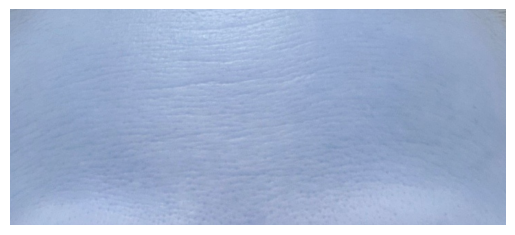

In [5]:
# 데이터 확인

print(test_data_sets.keys())
print(test_data_sets["Images"].keys())
print(test_data_sets["Metadata"].keys())

plt.imshow(test_data_sets["Images"]['0002_03_F_01'])
plt.axis("off")
plt.show()

In [8]:
test_data_sets["Metadata"]['0002_03_F_01']

{'info': {'filename': '0002_03_F.jpg',
  'id': '0002',
  'gender': 'F',
  'age': 50,
  'date': '2023-07-27',
  'skin_type': 0,
  'sensitive': 0},
 'images': {'device': 2,
  'width': 1920,
  'height': 2560,
  'angle': 0,
  'facepart': 1,
  'bbox': [788, 691, 1510, 1005]},
 'annotations': {'forehead_pigmentation': 1, 'forehead_wrinkle': 1},
 'equipment': {'forehead_moisture': 75.0,
  'forehead_elasticity_R0': 0.287,
  'forehead_elasticity_R1': 0.097,
  'forehead_elasticity_R2': 0.662,
  'forehead_elasticity_R3': 0.329,
  'forehead_elasticity_R4': 0.135,
  'forehead_elasticity_R5': 0.552,
  'forehead_elasticity_R6': 0.649,
  'forehead_elasticity_R7': 0.335,
  'forehead_elasticity_R8': 0.19,
  'forehead_elasticity_R9': 0.042,
  'forehead_elasticity_Q0': 57.4,
  'forehead_elasticity_Q1': 0.579,
  'forehead_elasticity_Q2': 0.438,
  'forehead_elasticity_Q3': 0.142}}

Target Distribution (Class Count):
Class 0: 175
Class 1: 443
Class 2: 163
Class 3: 69
Class 4: 6
Class 5: 2


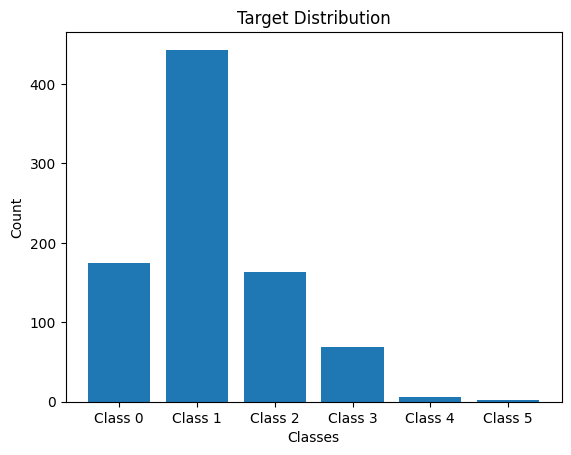

In [21]:
from collections import Counter

# 전체 데이터셋의 타겟 분포 확인
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)

# 분포 출력
print("Target Distribution (Class Count):")
for target, count in sorted(target_distribution.items()):
    print(f"Class {target}: {count}")

# 시각화를 위한 matplotlib 사용
import matplotlib.pyplot as plt

classes = sorted(target_distribution.keys())
counts = [target_distribution[c] for c in classes]

plt.bar(classes, counts, tick_label=[f"Class {c}" for c in classes])
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Target Distribution")
plt.show()


<h1>대략적인 양상을 보기 위한 선행 모델학습</h1>

In [20]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image

# Dataset 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.images = data["Images"]  # Images: numpy.ndarray 형태로 저장된 이미지들
        self.metadata = data["Metadata"]  # Metadata: JSON 메타데이터
        self.transform = transform
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet50 사전 학습 기준
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform)  # test_data_sets는 이미 로드된 상태로 사용
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ResNet50 모델 로드 및 수정
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)  # 출력 클래스 수를 6으로 수정 (0~5)

# 손실 함수 및 옵티마이저
criterion = nn.CrossEntropyLoss()  # 분류 문제에 적합한 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 학습률 0.001

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 10  # 에포크 수
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 모델 출력 및 손실 계산
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

# # 모델 저장
# torch.save(model.state_dict(), "resnet50_skin_model.pth")
# print("모델이 저장되었습니다.")


Epoch 1/10, Loss: 1.3547, Train Accuracy: 46.50%
Validation Accuracy: 9.88%
Epoch 2/10, Loss: 1.1175, Train Accuracy: 51.31%
Validation Accuracy: 25.00%
Epoch 3/10, Loss: 1.0445, Train Accuracy: 52.77%
Validation Accuracy: 56.40%
Epoch 4/10, Loss: 1.0050, Train Accuracy: 58.60%
Validation Accuracy: 37.79%
Epoch 5/10, Loss: 0.9645, Train Accuracy: 56.27%
Validation Accuracy: 44.77%
Epoch 6/10, Loss: 0.9581, Train Accuracy: 59.77%
Validation Accuracy: 57.56%
Epoch 7/10, Loss: 0.9834, Train Accuracy: 57.43%
Validation Accuracy: 48.84%
Epoch 8/10, Loss: 0.9383, Train Accuracy: 60.20%
Validation Accuracy: 48.26%
Epoch 9/10, Loss: 0.8833, Train Accuracy: 62.10%
Validation Accuracy: 51.74%
Epoch 10/10, Loss: 0.8018, Train Accuracy: 65.45%
Validation Accuracy: 46.51%


In [22]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from collections import Counter

# Dataset 클래스 정의
class SkinDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.images = data["Images"]  # Images: numpy.ndarray 형태로 저장된 이미지들
        self.metadata = data["Metadata"]  # Metadata: JSON 메타데이터
        self.transform = transform
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ResNet50 사전 학습 기준
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform)  # test_data_sets는 이미 로드된 상태로 사용
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스별 데이터 분포 계산
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)

# 클래스 가중치 계산 (전체 샘플 수 / 클래스별 샘플 수)
total_samples = len(targets)
class_weights = [total_samples / target_distribution[c] for c in range(6)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# ResNet50 모델 로드 및 수정
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)  # 출력 클래스 수를 6으로 수정 (0~5)

# Weighted Loss 설정
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 클래스 가중치 반영
optimizer = optim.Adam(model.parameters(), lr=0.001)  # 학습률 0.001

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 10  # 에포크 수
for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        # 옵티마이저 초기화
        optimizer.zero_grad()
        
        # 모델 출력 및 손실 계산
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")

# # 모델 저장
# torch.save(model.state_dict(), "resnet50_skin_model_with_weights.pth")
# print("모델이 저장되었습니다.")


c:\Dev\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Dev\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 2.0393, Train Accuracy: 27.55%
Validation Accuracy: 47.09%
Epoch 2/10, Loss: 1.6989, Train Accuracy: 26.38%
Validation Accuracy: 29.65%
Epoch 3/10, Loss: 1.6780, Train Accuracy: 27.99%
Validation Accuracy: 4.65%
Epoch 4/10, Loss: 1.5915, Train Accuracy: 31.34%
Validation Accuracy: 22.67%
Epoch 5/10, Loss: 1.4354, Train Accuracy: 26.82%
Validation Accuracy: 36.63%
Epoch 6/10, Loss: 1.4561, Train Accuracy: 34.69%
Validation Accuracy: 12.79%
Epoch 7/10, Loss: 1.2424, Train Accuracy: 38.78%
Validation Accuracy: 15.12%
Epoch 8/10, Loss: 1.2564, Train Accuracy: 40.09%
Validation Accuracy: 28.49%
Epoch 9/10, Loss: 1.3792, Train Accuracy: 38.78%
Validation Accuracy: 41.28%
Epoch 10/10, Loss: 1.2370, Train Accuracy: 40.23%
Validation Accuracy: 22.67%
모델이 저장되었습니다.


In [23]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from collections import Counter
from torchvision.transforms import functional as TF

# Dataset 클래스 정의 (증강 포함)
class SkinDataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        self.data = data
        self.images = data["Images"]
        self.metadata = data["Metadata"]
        self.transform = transform
        self.augment = augment
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        # 증강 적용 (소수 클래스만)
        if self.augment and target in [4, 5]:
            if torch.rand(1).item() > 0.5:
                image = TF.hflip(image)
            if torch.rand(1).item() > 0.5:
                image = TF.rotate(image, angle=torch.randint(-30, 30, (1,)).item())
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 가중치 계산
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)
total_samples = len(targets)
class_weights = [total_samples / target_distribution[c] for c in range(6)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# ResNet50 모델 로드 및 수정
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 6)

# Weighted Loss, Optimizer 및 Learning Rate Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 20

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # 학습률 조정
    scheduler.step()

print("학습 완료.")

Epoch 1/20, Loss: 2.0615, Train Accuracy: 24.49%
Validation Accuracy: 4.07%
Epoch 2/20, Loss: 1.5989, Train Accuracy: 30.47%
Validation Accuracy: 10.47%
Epoch 3/20, Loss: 1.3892, Train Accuracy: 34.40%
Validation Accuracy: 11.63%
Epoch 4/20, Loss: 1.5051, Train Accuracy: 31.05%
Validation Accuracy: 34.30%
Epoch 5/20, Loss: 1.2860, Train Accuracy: 31.92%
Validation Accuracy: 33.72%
Epoch 6/20, Loss: 1.3218, Train Accuracy: 38.92%
Validation Accuracy: 34.30%
Epoch 7/20, Loss: 1.4339, Train Accuracy: 34.55%
Validation Accuracy: 31.40%
Epoch 8/20, Loss: 1.2507, Train Accuracy: 36.59%
Validation Accuracy: 31.98%
Epoch 9/20, Loss: 1.2162, Train Accuracy: 37.32%
Validation Accuracy: 33.72%
Epoch 10/20, Loss: 1.2626, Train Accuracy: 39.80%
Validation Accuracy: 33.72%
Epoch 11/20, Loss: 1.1960, Train Accuracy: 40.82%
Validation Accuracy: 34.88%
Epoch 12/20, Loss: 1.2492, Train Accuracy: 38.92%
Validation Accuracy: 34.88%
Epoch 13/20, Loss: 1.3346, Train Accuracy: 39.36%
Validation Accuracy: 34.

In [24]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from collections import Counter
from torchvision.models import efficientnet_b0
from torchvision.transforms import functional as TF

# Dataset 클래스 정의 (증강 포함)
class SkinDataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        self.data = data
        self.images = data["Images"]
        self.metadata = data["Metadata"]
        self.transform = transform
        self.augment = augment
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        # 증강 적용 (전체 클래스)
        if self.augment:
            if torch.rand(1).item() > 0.5:
                image = TF.hflip(image)
            if torch.rand(1).item() > 0.5:
                image = TF.adjust_brightness(image, brightness_factor=torch.rand(1).item() + 0.5)
            if torch.rand(1).item() > 0.5:
                image = TF.rotate(image, angle=torch.randint(-30, 30, (1,)).item())
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 가중치 계산
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)
total_samples = len(targets)
class_weights = [total_samples / target_distribution[c] for c in range(6)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EfficientNet 모델 로드 및 수정
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)  # 출력 클래스 변경

# Weighted Loss, Optimizer 및 Learning Rate Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 20

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # 학습률 조정
    scheduler.step()

print("학습 완료.")

c:\Dev\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\oos04/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100.0%


Epoch 1/20, Loss: 1.7835, Train Accuracy: 30.32%
Validation Accuracy: 27.91%
Epoch 2/20, Loss: 1.5319, Train Accuracy: 31.63%
Validation Accuracy: 33.14%
Epoch 3/20, Loss: 1.4371, Train Accuracy: 36.30%
Validation Accuracy: 38.95%
Epoch 4/20, Loss: 1.4092, Train Accuracy: 39.65%
Validation Accuracy: 38.37%
Epoch 5/20, Loss: 1.3596, Train Accuracy: 41.69%
Validation Accuracy: 37.79%
Epoch 6/20, Loss: 1.2474, Train Accuracy: 43.88%
Validation Accuracy: 43.02%
Epoch 7/20, Loss: 1.1257, Train Accuracy: 45.63%
Validation Accuracy: 44.19%
Epoch 8/20, Loss: 1.1634, Train Accuracy: 47.81%
Validation Accuracy: 38.37%
Epoch 9/20, Loss: 1.1544, Train Accuracy: 45.34%
Validation Accuracy: 44.19%
Epoch 10/20, Loss: 1.1294, Train Accuracy: 49.56%
Validation Accuracy: 38.95%
Epoch 11/20, Loss: 1.1406, Train Accuracy: 47.08%
Validation Accuracy: 44.77%
Epoch 12/20, Loss: 1.1281, Train Accuracy: 49.56%
Validation Accuracy: 40.70%
Epoch 13/20, Loss: 1.1085, Train Accuracy: 47.81%
Validation Accuracy: 45

In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50
from torchvision import transforms
from PIL import Image
from collections import Counter
from torchvision.transforms import functional as TF

# ResNet50 기반 모델 정의
class CustomResNet50(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet50, self).__init__()
        # 사전 학습된 ResNet50 모델 로드
        self.resnet = resnet50(pretrained=True)
        
        # 마지막 Fully Connected 레이어 교체
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_accuracy):
        score = val_accuracy
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Dataset 클래스 정의 (증강 포함)
class SkinDataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        self.data = data
        self.images = data["Images"]
        self.metadata = data["Metadata"]
        self.transform = transform
        self.augment = augment
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        # 증강 적용 (전체 클래스)
        if self.augment:
            if torch.rand(1).item() > 0.5:
                image = TF.hflip(image)
            if torch.rand(1).item() > 0.5:
                image = TF.adjust_brightness(image, brightness_factor=torch.rand(1).item() + 0.5)
            if torch.rand(1).item() > 0.5:
                image = TF.rotate(image, angle=torch.randint(-30, 30, (1,)).item())
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 가중치 계산
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)
total_samples = len(targets)
class_weights = [total_samples / target_distribution[c] for c in range(6)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# 모델 생성
num_classes = 6  # 출력 클래스 수
model = CustomResNet50(num_classes=num_classes)

# Weighted Loss, Optimizer 및 Learning Rate Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 20
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # 학습률 조정
    scheduler.step()

    # Early Stopping 체크
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("학습 완료.")


Epoch 1/20, Loss: 1.8859, Train Accuracy: 23.91%
Validation Accuracy: 12.79%
Epoch 2/20, Loss: 1.7446, Train Accuracy: 26.53%
Validation Accuracy: 23.84%
Epoch 3/20, Loss: 1.6674, Train Accuracy: 24.78%
Validation Accuracy: 29.07%
Epoch 4/20, Loss: 1.6601, Train Accuracy: 27.99%
Validation Accuracy: 28.49%
Epoch 5/20, Loss: 1.6826, Train Accuracy: 36.73%
Validation Accuracy: 31.40%
Epoch 6/20, Loss: 1.5861, Train Accuracy: 34.84%
Validation Accuracy: 27.91%
Epoch 7/20, Loss: 1.5645, Train Accuracy: 35.86%
Validation Accuracy: 25.58%
Epoch 8/20, Loss: 1.5950, Train Accuracy: 31.20%
Validation Accuracy: 31.40%
Epoch 9/20, Loss: 1.5616, Train Accuracy: 33.67%
Validation Accuracy: 30.81%
Epoch 10/20, Loss: 1.5431, Train Accuracy: 32.36%
Validation Accuracy: 34.88%
Epoch 11/20, Loss: 1.5145, Train Accuracy: 32.51%
Validation Accuracy: 30.81%
Epoch 12/20, Loss: 1.5493, Train Accuracy: 36.59%
Validation Accuracy: 30.23%
Epoch 13/20, Loss: 1.4932, Train Accuracy: 38.19%
Validation Accuracy: 29

In [28]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np

# 데이터셋 클래스를 정의합니다.
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.images = list(data_dict["Images"].values())
        self.targets = [meta["annotations"]["forehead_pigmentation"] for meta in data_dict["Metadata"].values()]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # numpy.ndarray 이미지를 PIL 이미지로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# 데이터 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
dataset = CustomDataset(test_data_sets, transform=transform)

# 학습 데이터와 검증 데이터로 분리 (8:2 비율)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 사전학습된 ResNet50 모델 불러오기
model = models.resnet50(pretrained=True)

# 출력 클래스를 데이터셋에 맞게 조정
num_classes = len(set(meta["annotations"]["forehead_pigmentation"] for meta in test_data_sets["Metadata"].values()))  # 타겟의 고유 클래스 수 계산
model.fc = nn.Linear(2048, num_classes)  # Fully Connected Layer 수정

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 옵티마이저

# 정확도 계산 함수
def calculate_accuracy(loader, model):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# 학습 루프 정의
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 학습 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("모델 학습 완료!")


Epoch 1/10, Loss: 1.2685, Train Accuracy: 0.6254, Validation Accuracy: 0.4244
Epoch 2/10, Loss: 0.6120, Train Accuracy: 0.9242, Validation Accuracy: 0.4593
Epoch 3/10, Loss: 0.2055, Train Accuracy: 0.9636, Validation Accuracy: 0.4709
Epoch 4/10, Loss: 0.1053, Train Accuracy: 0.9883, Validation Accuracy: 0.4942
Epoch 5/10, Loss: 0.0979, Train Accuracy: 0.9840, Validation Accuracy: 0.5233
Epoch 6/10, Loss: 0.1211, Train Accuracy: 0.9227, Validation Accuracy: 0.4593
Epoch 7/10, Loss: 0.1519, Train Accuracy: 0.9752, Validation Accuracy: 0.5349
Epoch 8/10, Loss: 0.0995, Train Accuracy: 0.9402, Validation Accuracy: 0.5000
Epoch 9/10, Loss: 0.0819, Train Accuracy: 0.9752, Validation Accuracy: 0.4709
Epoch 10/10, Loss: 0.1018, Train Accuracy: 0.9883, Validation Accuracy: 0.4884
모델 학습 완료!


In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np

# 데이터셋 클래스를 정의합니다.
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None, augment=None):
        self.images = list(data_dict["Images"].values())
        self.targets = [meta["annotations"]["forehead_pigmentation"] for meta in data_dict["Metadata"].values()]
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # numpy.ndarray 이미지를 PIL 이미지로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # 증강 적용 (소수 클래스만)
        if self.augment and target in [4, 5]:
            if np.random.rand() > 0.5:
                image = transforms.functional.hflip(image)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_brightness(image, brightness_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_contrast(image, contrast_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.rotate(image, angle=np.random.uniform(-30, 30))

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# 데이터 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
dataset = CustomDataset(test_data_sets, transform=transform, augment=True)

# 학습 데이터와 검증 데이터로 분리 (8:2 비율)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 사전학습된 ResNet50 모델 불러오기
model = models.resnet50(pretrained=True)

# 출력 클래스를 데이터셋에 맞게 조정
num_classes = len(set(meta["annotations"]["forehead_pigmentation"] for meta in test_data_sets["Metadata"].values()))  # 타겟의 고유 클래스 수 계산
model.fc = nn.Linear(2048, num_classes)  # Fully Connected Layer 수정

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 옵티마이저

# 정확도 계산 함수
def calculate_accuracy(loader, model):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# 학습 루프 정의
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 학습 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

print("모델 학습 완료!")


Epoch 1/10, Loss: 1.3090, Train Accuracy: 0.6414, Validation Accuracy: 0.4651
Epoch 2/10, Loss: 0.6475, Train Accuracy: 0.8761, Validation Accuracy: 0.5058
Epoch 3/10, Loss: 0.2586, Train Accuracy: 0.9344, Validation Accuracy: 0.4593
Epoch 4/10, Loss: 0.1300, Train Accuracy: 0.9942, Validation Accuracy: 0.4360
Epoch 5/10, Loss: 0.0893, Train Accuracy: 0.9913, Validation Accuracy: 0.4826
Epoch 6/10, Loss: 0.1279, Train Accuracy: 0.9679, Validation Accuracy: 0.4709
Epoch 7/10, Loss: 0.1304, Train Accuracy: 0.8950, Validation Accuracy: 0.4709
Epoch 8/10, Loss: 0.1578, Train Accuracy: 0.9927, Validation Accuracy: 0.5058
Epoch 9/10, Loss: 0.1785, Train Accuracy: 0.9548, Validation Accuracy: 0.4651
Epoch 10/10, Loss: 0.1449, Train Accuracy: 0.9840, Validation Accuracy: 0.5174
모델 학습 완료!


In [30]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np

# 데이터셋 클래스를 정의합니다.
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None, augment=None):
        self.images = list(data_dict["Images"].values())
        self.targets = [meta["annotations"]["forehead_pigmentation"] for meta in data_dict["Metadata"].values()]
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # numpy.ndarray 이미지를 PIL 이미지로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # 증강 적용 (소수 클래스만)
        if self.augment and target in [4, 5]:
            if np.random.rand() > 0.5:
                image = transforms.functional.hflip(image)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_brightness(image, brightness_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_contrast(image, contrast_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.rotate(image, angle=np.random.uniform(-30, 30))

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# 데이터 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
dataset = CustomDataset(test_data_sets, transform=transform, augment=True)

# 학습 데이터와 검증 데이터로 분리 (8:2 비율)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ResNet50 기반 모델 정의
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout 추가
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 출력 클래스를 데이터셋에 맞게 조정
num_classes = len(set(meta["annotations"]["forehead_pigmentation"] for meta in test_data_sets["Metadata"].values()))  # 타겟의 고유 클래스 수 계산
model = ModifiedResNet50(num_classes=num_classes)
model = model.to(device)

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 옵티마이저
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_accuracy = 0
        self.early_stop = False

    def __call__(self, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=5)

# 정확도 계산 함수
def calculate_accuracy(loader, model):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# 학습 루프 정의
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 학습 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Learning Rate Scheduler 스텝
    scheduler.step()

    # Early Stopping 체크
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("모델 학습 완료!")


Epoch 1/10, Loss: 1.3148, Train Accuracy: 0.6224, Validation Accuracy: 0.4942
Epoch 2/10, Loss: 0.7529, Train Accuracy: 0.8251, Validation Accuracy: 0.5407
Epoch 3/10, Loss: 0.3854, Train Accuracy: 0.9679, Validation Accuracy: 0.5291
Epoch 4/10, Loss: 0.2044, Train Accuracy: 0.9942, Validation Accuracy: 0.5988
Epoch 5/10, Loss: 0.0976, Train Accuracy: 0.9810, Validation Accuracy: 0.4535
Epoch 6/10, Loss: 0.0769, Train Accuracy: 0.9942, Validation Accuracy: 0.5349
Epoch 7/10, Loss: 0.0602, Train Accuracy: 1.0000, Validation Accuracy: 0.5523
Epoch 8/10, Loss: 0.0467, Train Accuracy: 0.9971, Validation Accuracy: 0.5233
Epoch 9/10, Loss: 0.0272, Train Accuracy: 0.9985, Validation Accuracy: 0.5349
Early stopping triggered.
모델 학습 완료!


In [32]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np

# 데이터셋 클래스를 정의합니다.
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None, augment=None):
        self.images = list(data_dict["Images"].values())
        self.targets = [meta["annotations"]["forehead_pigmentation"] for meta in data_dict["Metadata"].values()]
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # numpy.ndarray 이미지를 PIL 이미지로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # 증강 적용 (소수 클래스만)
        if self.augment and target in [4, 5]:
            if np.random.rand() > 0.5:
                image = transforms.functional.hflip(image)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_brightness(image, brightness_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_contrast(image, contrast_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.rotate(image, angle=np.random.uniform(-30, 30))

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# 데이터 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
dataset = CustomDataset(test_data_sets, transform=transform, augment=True)

# 학습 데이터와 검증 데이터로 분리 (8:2 비율)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ResNet50 기반 모델 정의
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout 추가
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 출력 클래스를 데이터셋에 맞게 조정
num_classes = len(set(meta["annotations"]["forehead_pigmentation"] for meta in test_data_sets["Metadata"].values()))  # 타겟의 고유 클래스 수 계산
model = ModifiedResNet50(num_classes=num_classes)
model = model.to(device)

# 클래스 가중치 계산 및 CrossEntropyLoss에 적용
class_counts = [175, 443, 163, 69, 6, 2]  # 클래스별 샘플 개수
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 손실 함수에 클래스 가중치 적용

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 옵티마이저
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_accuracy = 0
        self.early_stop = False

    def __call__(self, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=5)

# 정확도 계산 함수
def calculate_accuracy(loader, model):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return correct / total

# 학습 루프 정의
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 학습 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Learning Rate Scheduler 스텝
    scheduler.step()

    # Early Stopping 체크
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("모델 학습 완료!")


Epoch 1/20, Loss: 1.6680, Train Accuracy: 0.5058, Validation Accuracy: 0.4651
Epoch 2/20, Loss: 1.2231, Train Accuracy: 0.7012, Validation Accuracy: 0.4942
Epoch 3/20, Loss: 0.8784, Train Accuracy: 0.8571, Validation Accuracy: 0.5523
Epoch 4/20, Loss: 0.7907, Train Accuracy: 0.8076, Validation Accuracy: 0.5000
Epoch 5/20, Loss: 0.7268, Train Accuracy: 0.9388, Validation Accuracy: 0.5233
Epoch 6/20, Loss: 0.4286, Train Accuracy: 0.9694, Validation Accuracy: 0.5349
Epoch 7/20, Loss: 0.3272, Train Accuracy: 0.9825, Validation Accuracy: 0.5698
Epoch 8/20, Loss: 0.2619, Train Accuracy: 0.9869, Validation Accuracy: 0.5640
Epoch 9/20, Loss: 0.2285, Train Accuracy: 0.9898, Validation Accuracy: 0.5407
Epoch 10/20, Loss: 0.2618, Train Accuracy: 0.9927, Validation Accuracy: 0.5523
Epoch 11/20, Loss: 0.2209, Train Accuracy: 0.9942, Validation Accuracy: 0.5349
Epoch 12/20, Loss: 0.2581, Train Accuracy: 0.9898, Validation Accuracy: 0.5349
Early stopping triggered.
모델 학습 완료!


<h1>한등급차이 맞다고 인정</h1>

In [33]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from PIL import Image
import numpy as np

# 데이터셋 클래스를 정의합니다.
class CustomDataset(Dataset):
    def __init__(self, data_dict, transform=None, augment=None):
        self.images = list(data_dict["Images"].values())
        self.targets = [meta["annotations"]["forehead_pigmentation"] for meta in data_dict["Metadata"].values()]
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        # numpy.ndarray 이미지를 PIL 이미지로 변환
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)

        # 증강 적용 (소수 클래스만)
        if self.augment and target in [4, 5]:
            if np.random.rand() > 0.5:
                image = transforms.functional.hflip(image)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_brightness(image, brightness_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.adjust_contrast(image, contrast_factor=1.2)
            if np.random.rand() > 0.5:
                image = transforms.functional.rotate(image, angle=np.random.uniform(-30, 30))

        # Transform 적용
        if self.transform:
            image = self.transform(image)

        return image, target

# 데이터 변환(transform)을 정의합니다.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기에 맞춤
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 생성
dataset = CustomDataset(test_data_sets, transform=transform, augment=True)

# 학습 데이터와 검증 데이터로 분리 (8:2 비율)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ResNet50 기반 모델 정의
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),  # Dropout 추가
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

# 출력 클래스를 데이터셋에 맞게 조정
num_classes = len(set(meta["annotations"]["forehead_pigmentation"] for meta in test_data_sets["Metadata"].values()))  # 타겟의 고유 클래스 수 계산
model = ModifiedResNet50(num_classes=num_classes)
model = model.to(device)

# 클래스 가중치 계산 및 CrossEntropyLoss에 적용
class_counts = [175, 443, 163, 69, 6, 2]  # 클래스별 샘플 개수
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # 손실 함수에 클래스 가중치 적용

# 모델 학습 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # 옵티마이저
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_accuracy = 0
        self.early_stop = False

    def __call__(self, val_accuracy):
        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Early Stopping 초기화
early_stopping = EarlyStopping(patience=5)

# 정확도 계산 함수 (한 단계 차이를 맞은 것으로 인정)
def calculate_accuracy(loader, model):
    model.eval()  # 평가 모드
    correct = 0
    total = 0
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += ((predicted == targets) | (torch.abs(predicted - targets) == 1)).sum().item()
    return correct / total

# 학습 루프 정의
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 학습 모드
    running_loss = 0.0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # 학습 및 검증 정확도 계산
    train_accuracy = calculate_accuracy(train_loader, model)
    val_accuracy = calculate_accuracy(val_loader, model)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, "
          f"Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Learning Rate Scheduler 스텝
    scheduler.step()

    # Early Stopping 체크
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("모델 학습 완료!")


Epoch 1/10, Loss: 1.7560, Train Accuracy: 0.9082, Validation Accuracy: 0.8721
Epoch 2/10, Loss: 1.3419, Train Accuracy: 0.9621, Validation Accuracy: 0.9477
Epoch 3/10, Loss: 0.9562, Train Accuracy: 0.9650, Validation Accuracy: 0.9186
Epoch 4/10, Loss: 0.7141, Train Accuracy: 0.9942, Validation Accuracy: 0.9535
Epoch 5/10, Loss: 0.4647, Train Accuracy: 0.9854, Validation Accuracy: 0.9186
Epoch 6/10, Loss: 0.3188, Train Accuracy: 0.9956, Validation Accuracy: 0.9477
Epoch 7/10, Loss: 0.2542, Train Accuracy: 0.9985, Validation Accuracy: 0.9651
Epoch 8/10, Loss: 0.2615, Train Accuracy: 0.9985, Validation Accuracy: 0.9593
Epoch 9/10, Loss: 0.2543, Train Accuracy: 0.9985, Validation Accuracy: 0.9535
Epoch 10/10, Loss: 0.1947, Train Accuracy: 0.9985, Validation Accuracy: 0.9651
모델 학습 완료!


<h1>efficientnet_b0 사용</h1>

In [25]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from collections import Counter
from torchvision.models import efficientnet_b0
from torchvision.transforms import functional as TF

# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, val_accuracy):
        score = val_accuracy
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# Dataset 클래스 정의 (증강 포함)
class SkinDataset(Dataset):
    def __init__(self, data, transform=None, augment=False):
        self.data = data
        self.images = data["Images"]
        self.metadata = data["Metadata"]
        self.transform = transform
        self.augment = augment
        self.keys = list(self.metadata.keys())  # 데이터 키 리스트
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        image_data = self.images[key]  # numpy.ndarray 이미지 데이터
        metadata = self.metadata[key]  # 메타데이터
        
        # numpy.ndarray 이미지를 PIL 이미지로 변환
        image = Image.fromarray(image_data)
        
        # 타겟 레이블 (forehead_pigmentation)
        target = metadata["annotations"]["forehead_pigmentation"]
        
        # 증강 적용 (전체 클래스)
        if self.augment:
            if torch.rand(1).item() > 0.5:
                image = TF.hflip(image)
            if torch.rand(1).item() > 0.5:
                image = TF.adjust_brightness(image, brightness_factor=torch.rand(1).item() + 0.5)
            if torch.rand(1).item() > 0.5:
                image = TF.rotate(image, angle=torch.randint(-30, 30, (1,)).item())
        
        if self.transform:
            image = self.transform(image)
        
        return image, target

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Dataset 및 Train/Validation Split
dataset = SkinDataset(test_data_sets, transform=transform, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 클래스 가중치 계산
targets = [metadata["annotations"]["forehead_pigmentation"] for metadata in test_data_sets["Metadata"].values()]
target_distribution = Counter(targets)
total_samples = len(targets)
class_weights = [total_samples / target_distribution[c] for c in range(6)]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# EfficientNet 모델 로드 및 수정
model = efficientnet_b0(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 6)  # 출력 클래스 변경

# Dropout 확률 설정
for module in model.modules():
    if isinstance(module, nn.Dropout):
        module.p = 0.3

# Weighted Loss, Optimizer 및 Learning Rate Scheduler
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

# GPU/CPU 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 학습 및 검증 루프
num_epochs = 20
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)
    
    train_accuracy = correct_train / total_train * 100
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
    
    # Validation
    model.eval()
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(device), targets.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == targets).sum().item()
            total_val += targets.size(0)
    
    val_accuracy = correct_val / total_val * 100
    print(f"Validation Accuracy: {val_accuracy:.2f}%")
    
    # 학습률 조정
    scheduler.step()

    # Early Stopping 체크
    early_stopping(val_accuracy)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

print("학습 완료.")


Epoch 1/20, Loss: 1.7825, Train Accuracy: 28.72%
Validation Accuracy: 38.37%
Epoch 2/20, Loss: 1.5110, Train Accuracy: 37.76%
Validation Accuracy: 38.37%
Epoch 3/20, Loss: 1.5181, Train Accuracy: 37.46%
Validation Accuracy: 37.21%
Epoch 4/20, Loss: 1.4345, Train Accuracy: 38.92%
Validation Accuracy: 27.91%
Epoch 5/20, Loss: 1.3348, Train Accuracy: 38.92%
Validation Accuracy: 29.07%
Epoch 6/20, Loss: 1.2843, Train Accuracy: 45.92%
Validation Accuracy: 38.37%
Epoch 7/20, Loss: 1.2658, Train Accuracy: 47.08%
Validation Accuracy: 37.79%
Epoch 8/20, Loss: 1.2549, Train Accuracy: 45.19%
Validation Accuracy: 31.98%
Epoch 9/20, Loss: 1.2213, Train Accuracy: 45.63%
Validation Accuracy: 37.21%
Epoch 10/20, Loss: 1.2483, Train Accuracy: 47.23%
Validation Accuracy: 31.40%
Epoch 11/20, Loss: 1.1777, Train Accuracy: 47.08%
Validation Accuracy: 34.30%
Early stopping triggered.
학습 완료.
